[View in Colaboratory](https://colab.research.google.com/github/Iamnotabear/GANs/blob/master/CDGAN_.ipynb)

In [1]:
#importing all the libraries and frameworks
import keras

from keras import layers
import numpy as np
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
latent_dim = 32 #dimensions of the random latent vectors
height = 32 #height of image
width = 32 #width of image
channels = 3 #RGB

In [3]:
generator_input = keras.Input(shape=(latent_dim,)) #the shape of input layer to be feede in the model

x = layers.Dense(128 * 16 * 16)(generator_input) #connecting the input layer to a fully connected neural layer
x = layers.LeakyReLU()(x) #applying activation 
x = layers.Reshape((16, 16, 128))(x) #reshaping the activation output into a 3-d output of 16x16x128

x = layers.Conv2D(256, 5, padding='same')(x) #convolving over the previously reshaped 3-d output
x = layers.LeakyReLU()(x) #applying leaky_relu activation

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) # transpose convolution for upsampling the previously convolved layer
x = layers.LeakyReLU()(x) #applying leaky_relu activation

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

#convolving again to produce a output of shape of our image 32*32*3 with a tanh activation
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x) 

#model
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [4]:
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x) #flattening the convoloved layer to connect it to a fully connected layer

x = layers.Dropout(0.4)(x) #dropouting to reduce overfitting

x = layers.Dense(1, activation='sigmoid')(x) #single output therefore a sigmoid would do

#model
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

##CLASSIFICATION TIME!!!

# using RMS(root mean square) optimizer 
# learning rate = 0.0008, clipping gradient with a limit of 1
# learning  decay rate = 10^(-8)
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

# compiling over loss function i.e binary cross-entropy 
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [0]:
#freezing the training of discriminator just for the gan model "ONLY"
discriminator.trainable = False

#input shape for gan model
gan_input = keras.Input(shape=(latent_dim,))

#gan model
gan_output = discriminator(generator(gan_input))

#model
gan = keras.models.Model(gan_input, gan_output)

# using RMS(root mean square) optimizer 
# learning rate = 0.0008, clipping gradient with a limit of 1
# learning  decay rate = 10^(-8)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)

# compiling over loss function i.e binary cross-entropy
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [6]:
# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select ship images (class 8)
x_train = x_train[y_train.flatten() == 8]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.


iterations = 10000
batch_size = 20


170500096/170498071 [==============================] - 80s 0us/step


In [7]:


# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6895398
adversarial loss at step 0: 0.6423186
discriminator loss at step 100: 0.62522537
adversarial loss at step 100: 0.93457496
discriminator loss at step 200: 0.6793529
adversarial loss at step 200: 0.83407134
discriminator loss at step 300: 0.6920221
adversarial loss at step 300: 0.7255963
discriminator loss at step 400: 0.69350064
adversarial loss at step 400: 0.7913539
discriminator loss at step 500: 0.685209
adversarial loss at step 500: 0.72170097
discriminator loss at step 600: 0.69840944
adversarial loss at step 600: 0.70091707
discriminator loss at step 700: 0.6877507
adversarial loss at step 700: 0.7321669
discriminator loss at step 800: 0.6936064
adversarial loss at step 800: 0.86737
discriminator loss at step 900: 0.69520444
adversarial loss at step 900: 0.7467545
discriminator loss at step 1000: 0.69727635
adversarial loss at step 1000: 0.73915476
discriminator loss at step 1100: 0.690197
adversarial loss at step 1100: 0.7637652
discrimina

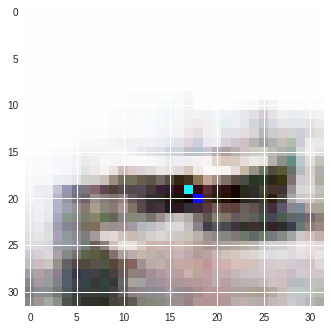

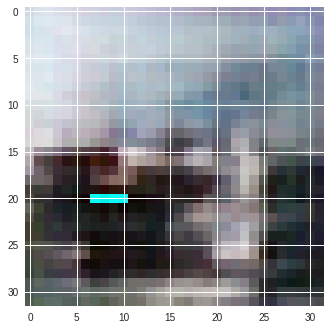

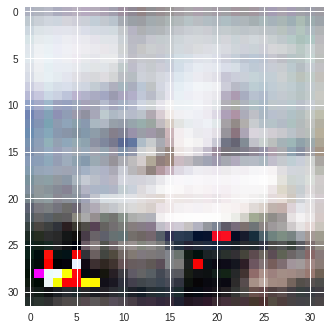

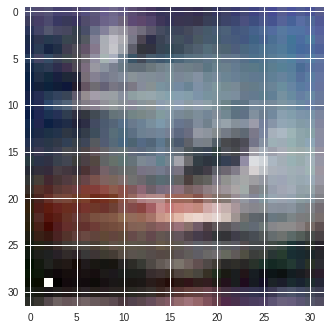

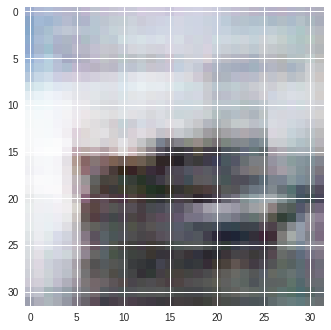

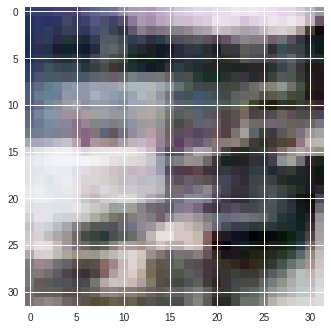

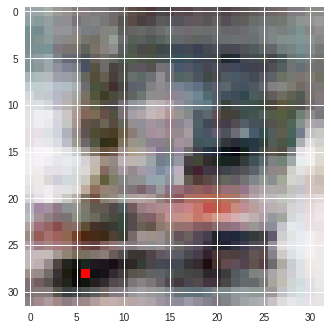

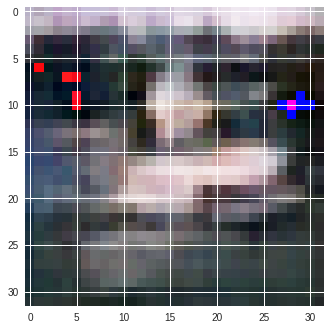

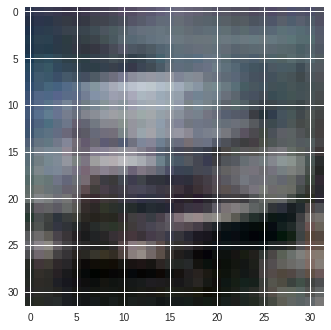

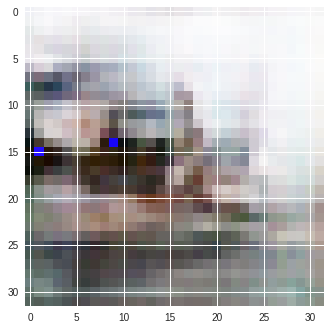

In [8]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))

#generating images from learned layers of our generator model
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()